# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also defining where to put the model weights

In [5]:
import torch
import torch.nn.functional as F
from torchattacks import *
from torchvision import transforms, models 
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2
import glob
from torch.autograd import Variable
from captum.attr import IntegratedGradients

train_again = True

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {DEVICE} device")

# Path to saving the attack
if train_again == True:
    atk_path = "/zhome/06/a/147115/BSc_venv/BachelorProject_XAI/plottables/AttackImnet/AttacksVGGImnet_"
else:
    atk_path = "/Users/Alex/Documents/results/plotables/AttacksVGGImnet.pth"
print(f"Saving model in path: {atk_path}")

# Path to data folder
imagePath = "Imagenet_pics"


Using cpu device
Saving model in path: /zhome/06/a/147115/BSc_venv/BachelorProject_XAI/plottables/AttackImnet/AttacksVGGImnet_


## Downloading data

Downloading photo folder. First the processing functions. Pre- and deprocessing of the image

In [3]:

def preprocess(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.ToPILImage(),
    ])
    return transform(image)

# Load and process images
images_cv = [cv2.imread(file) for file in glob.glob('Imagenet_pics/*.JPEG')]
images = [cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) for im_cv in images_cv]
imgs_var = [Variable(preprocess(im), requires_grad=True).to(DEVICE) for im in images]

# defining labels for imagenet
labels_link = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"    
labels = requests.get(labels_link).json()




## Model under attack

The model obviously also needs to be defined:

In [4]:
#Using VGG-19 pretrained model for image classification
model = models.vgg19(pretrained=True).to(DEVICE)
#for param in model.parameters():
#    param.requires_grad = False

model.eval()
print()

Plot each image and their predictions

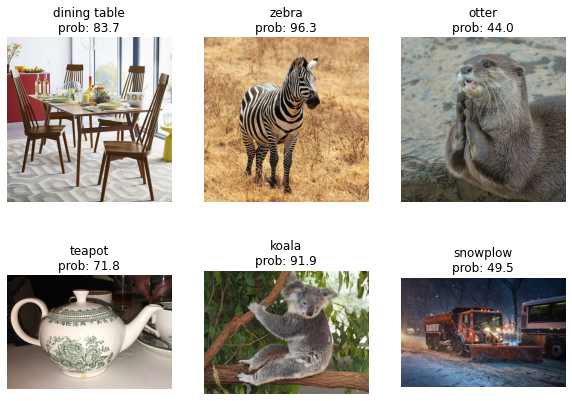

In [5]:

cnt = 1
label_idx = []

plt.figure(figsize=(10,15))


for i in range(len(images)):
        
    output = model(imgs_var[i])
    idx = torch.argmax(output).unsqueeze(0) #torch.max(output.data, 1)   #get an index(class number) of a largest element
    label_idx.append(idx)

    x_pred = labels[idx.item()]
        

    # Probability 
    output_probs = F.softmax(output, dim=1)
    x_pred_prob =  output_probs.max()*100

    plt.subplot(len(imgs_var)//3+2,3,cnt)
    plt.axis('off')
    plt.title(f"{x_pred}\nprob: {x_pred_prob:.1f}")
    plt.imshow(images[i])

    cnt +=1





# Different attacks on the model

In [6]:
atks = [
    VANILA(model),
    FGSM(model, eps=8/255),
    BIM(model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    GN(model, std=0.1),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]



def saliencyMapSingleImage(model, data, label):
    
    # Zero all existing gradient
    model.zero_grad()
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad_()
    data.retain_grad()
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    scores = model(data)
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max = scores[0,label]
   
    # Compute gradient of score_max with respect to the model
    score_max.backward()
    
    # flatten to one channel
    saliency_mean_abs = torch.mean(data.grad.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
    saliency_max_abs, _ = torch.max(data.grad.abs(), dim=1)

    return saliency_max_abs#, saliency_mean_abs



def intergratedGradSingleImage(model,data,label, trans: bool = False):
    ig = IntegratedGradients(model)
    model.zero_grad()
    attr_ig, delta = ig.attribute(data, target=label.to(DEVICE),baselines=data * 0, return_convergence_delta=True)

    attr_ig, _ = torch.max(attr_ig[0], dim=0,  keepdim=True) # 1 channel
    if trans:
        attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    return attr_ig
 

def advAtkSingleImage(image,label, atk):
    # Attack and Saliency maps
    print("\tAdversarial example")
    adv_image = atk(image, label)
    print("\tSaliency map")
    saliency_grad = saliencyMapSingleImage(model, image, label)
    print("\tIntergrated gradient")
    saliency_intgrad = intergratedGradSingleImage(model, image, label)
    
    # Label and Probability 
    output_adv = model(adv_image)
    label_idx_adv = torch.argmax(output_adv).unsqueeze(0)
    x_pred_prob_adv = F.softmax(output_adv, dim=1).max()*100

    # Determind noise: avd = img + noise => noise = avd - img
    noise = adv_image - image
    noise, _ = torch.max(noise[0], dim=0,  keepdim=True) # 1 channel
    
    # Save info in lists
    adv_dir =  [adv_image, noise, saliency_grad, saliency_intgrad] #['a','b']#[adv_image, noise]
    pred_dir = [label_idx_adv,x_pred_prob_adv] #{"label":label_idx_adv,"prob": x_pred_prob_adv}
    
    return adv_dir, pred_dir





Begin attacking!

In [7]:
if train_again == True:
    
    
    for idx, im in enumerate(imgs_var):
        print("_"*70 +" Image "+str(idx+1))
        # Initialization
        adv_images = []
        pred_images = []
        adv_name = []

        for atk in atks:
            print("_"*35)
            print(atk.__class__.__name__)
            
            # Perform attack on image
            adv_im, adv_pred = advAtkSingleImage(im, label_idx[idx], atk)

            adv_images.append(adv_im)
            pred_images.append(adv_pred)
            adv_name.append(atk.__class__.__name__)
        

        torch.save({"adv_name": adv_name, "adv_images" : adv_images, "pred_images" : pred_images}, atk_path + str(idx) + ".pth")
        del adv_images, pred_images, adv_name 



______________________________________________________________________ Image 1
___________________________________
VANILA
	Adversarial example
	Saliency map
	Intergrated gradient


KeyboardInterrupt: 

## Plotting 
Function to make plot, with different attackt and their saliency maps

In [82]:
def plotAttacksTable(atks,adv_images, pred_images):
    cnt = 0

    fig1 = plt.figure(figsize=(7,5))
    fig1.patch.set_facecolor('white')

    for i in range(len(atks)):
        for j in range(len(adv_images[0])):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # For adversarial example
                ex  = deprocess(adv_images[i][j])
                plt.ylabel(atks[i].__class__.__name__)
                plt.title(f"{labels[pred_images[i][0].item()]}\nProb: {pred_images[i][1].item():.1f}")#title(pred_images[i][1].item())#
                plt.imshow(ex)
            elif j == 1: # For the noise 
                ex,_ = torch.max(adv_images[i][j][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title("Noise")
                plt.imshow(ex.max()-ex,cmap= 'gray')
            elif j == 2: # Saliency map
                ex = adv_images[i][j][0]
            

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                plt.title('Saliency map')
                plt.imshow(ex.max() - ex, cmap='gray')
                

            else: # intergrated gradient
                
                ex = adv_images[i][j]
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title('Intergrated \ngradient')
                plt.imshow(ex.max()-ex,cmap= 'gray')
                #plt.imshow(saliency_show.max() - saliency_show, cmap = 'gray')


            
    #plt.tight_layout()
    plt.show()
    print()


/Users/Alex/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/Alex/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/Alex/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/Alex/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


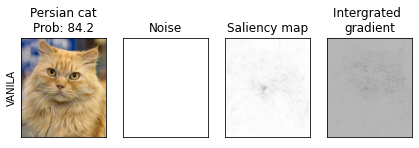

In [83]:

if train_again == False:
    # Loading!
    #attack = torch.load(atk_path,map_location = torch.device(DEVICE))
    #adv_images = attack["adv_images"]
    #pred_images = attack["pred_images"]
    #adv_name = attack["adv_names"]
    #saliency_im = attack["saliencyMap"]
    #saliency_im = saliencyMapSingleImage(model, img_variable)
    plotAttacksTable(atks,adv_images, pred_images)



### Plot histogram of noise

In [84]:
if train_again == False:
    
    atk_testidx = [3,5,20,0,1]

    fig2 = plt.figure(figsize=(15,25))
    fig2.patch.set_facecolor('white')
    x_range = [0, 1]
    y_range = [0,800]
    count = 0

    
    for i in atk_testidx:
        count +=1

        ex,_ = torch.max(adv_images[i][1][0], dim=0,  keepdim=True)
        ex = np.transpose(ex.detach(), (1,2,0))
        # standardize 
        ex = (ex - ex.min())/(ex.max() -ex.min())
        #print(ex.min(),ex.max())
    
        histogram, bin_edges = np.histogram(ex, bins=1000, range=(x_range[0], x_range[1]))
        plt.subplot(len(atk_testidx), 2,count)
        plt.title(atks[i].__class__.__name__)
        plt.xlabel("grayscale value")
        plt.ylabel("pixel count")
        plt.xlim(x_range)  # <- named arguments do not work here
        plt.ylim(y_range)

        plt.plot(bin_edges[0:-1], histogram) 

        
    ex = (saliency_im - saliency_im.min())/(saliency_im.max() -saliency_im.min())

    histogram, bin_edges = np.histogram(ex, bins=1000, range=(x_range[0], x_range[1]))

    plt.subplot(len(atk_testidx), 2,count +1)
    plt.title("Saliency maps")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel count")
    plt.xlim(x_range)  # <- named arguments do not work here
    plt.ylim(y_range)
    plt.plot(bin_edges[0:-1], histogram)

    plt.show()


IndexError: list index out of range

<Figure size 1080x1800 with 0 Axes>

### Binaries interesting noise

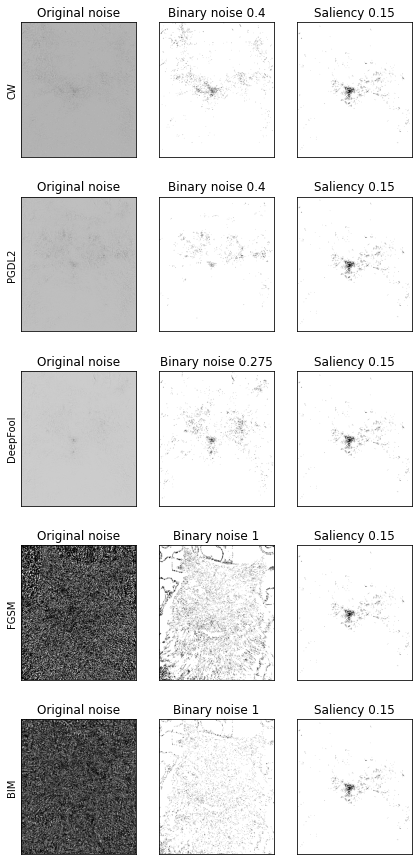

In [ ]:
if train_again == False:
    def bin_image(image,threshold):
        return (image<threshold).int()

    cnt = 0
    count = 0
    threshold = [0.4,0.4,0.275,1,1] # idx: [3,5,20,0,1]
    thresholdS = 0.15

    fig1 = plt.figure(figsize=(7,70))
    fig1.patch.set_facecolor('white')

    for i in atk_testidx:
        for j in range(len(adv_images[0])+1):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]) + 1,cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # Noise
                ex,_ = torch.max(adv_images[i][j+1][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title("Original noise")
                plt.ylabel(atks[i].__class__.__name__)
                plt.imshow(ex.max()-ex,cmap= 'gray')
            elif j == 1: # Bin noise
                ex,_ = torch.max(adv_images[i][j][0], dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
                ex_bin = bin_image(ex,threshold[count])
                plt.title(f"Binary noise {threshold[count]}")
                plt.imshow(ex_bin,cmap= 'gray')

                count += 1

            else: # Saliency map!
                plt.title(f'Saliency {thresholdS}')

                ex,_ = torch.max(saliency_im, dim=0,  keepdim=True)
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                ex_bin = bin_image(ex,thresholdS)
                plt.imshow(ex_bin, cmap = 'gray')


            
    #plt.tight_layout()
    plt.show()
    print() # make saliency map of attacked image, more examples, more saliency maps? kig på TPDG

## Sanity check: noise correctly?

In [10]:
if False:
    for i in range(18):
        # noise [i][1]
        noise_test = adv_images[i][1][0]
        # attacked img [i][0]
        adv_test = adv_images[i][0][0]

        
        #print(noise_test.size(),adv_test.size(),img_variable[0].size())
        
        img_noise = img_variable[0] + noise_test

        test0 = img_noise - adv_test

        print(atks[i].__class__.__name__, test0.min().item(),test0.max().item())
    






Convert to py file

In [12]:
!jupyter nbconvert --to script 'torchattacks_IMAGENET_test.ipynb'

[NbConvertApp] Converting notebook torchattacks_IMAGENET_test.ipynb to script
[NbConvertApp] Writing 13904 bytes to torchattacks_IMAGENET_test.py
